In [1]:
import wandb

wandb.init(project="test3", entity="xhradskyp")

wandb: Currently logged in as: xhradskyp. Use `wandb login --relogin` to force relogin


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchvision
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from datetime import datetime
from torch.utils.data import random_split
from torchmetrics.functional import dice

In [2]:
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

net = UNET(3, 1)

In [3]:
def extract_blocks(images):
    count,M,N,ch = images.shape
    w, h = 64, 64
    new = np.empty((count*49, w, h, ch), dtype=np.uint8)
    i = 0
    for image in images:
        for j in range(7):
            for k in range(7):
                new[i] = image[k*32:(k+1)*64-k*32, j*32:(j+1)*64-j*32]
                i += 1
    return new

class MyDataset(Dataset):
    def __init__(self):
        images = np.load("data/images.npy")
        labels = np.load("data/labels.npy")
        
        images = extract_blocks(images)
        print("done")
        labels = extract_blocks(labels)
        print("done")
        labels = labels[..., 1]
        labels[labels >= 1] = 1
        print("done")
        
        images = torch.tensor(images)
        labels = torch.tensor(labels)
        print(images.shape)
        self.images = images.permute((0, 3, 1, 2))
        self.labels = labels

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return self.images.shape[0]

In [4]:
dataset = MyDataset()

done
done
done


KeyboardInterrupt: 

In [ ]:
x = 123
plt.imshow(dataset[x][0].float().permute((1, 2, 0)).detach().numpy()/255)
plt.title("image")
plt.show()
plt.imshow(dataset[x][1].float().detach().numpy())
plt.title("mask")
plt.show()

In [ ]:
train_data, test_data = random_split(dataset, [200000, 44069])
dataloader = DataLoader(dataset=train_data, batch_size=8, shuffle=True)

In [8]:
num_epochs = 2
total_samples = len(train_data)
n_iterations = math.ceil(total_samples/8)
print(total_samples, n_iterations)
net = UNET(3, 1)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

200000 25000


epoch 1/2, step 100/25000, loss 404.44083461761477, acc 0.4888637661933899, time 0:00:37.935891
epoch 1/2, step 200/25000, loss 372.98533411026, acc 0.16643431782722473, time 0:01:06.666037
epoch 1/2, step 300/25000, loss 355.52426891326905, acc 0.43134379386901855, time 0:01:35.406392
epoch 1/2, step 400/25000, loss 371.29889993667604, acc 0.5250762104988098, time 0:02:04.354159
epoch 1/2, step 500/25000, loss 354.40777430534365, acc 0.3426474332809448, time 0:02:35.172091
epoch 1/2, step 600/25000, loss 381.8224225997925, acc 0.35329321026802063, time 0:03:05.477590
epoch 1/2, step 700/25000, loss 345.4214683532715, acc 0.3257901072502136, time 0:03:36.643452
epoch 1/2, step 800/25000, loss 371.78721103668215, acc 0.38676249980926514, time 0:04:08.759550
epoch 1/2, step 900/25000, loss 365.93734378814696, acc 0.3277342617511749, time 0:04:41.371874
epoch 1/2, step 1000/25000, loss 372.8950777053833, acc 0.4548764228820801, time 0:05:13.387807


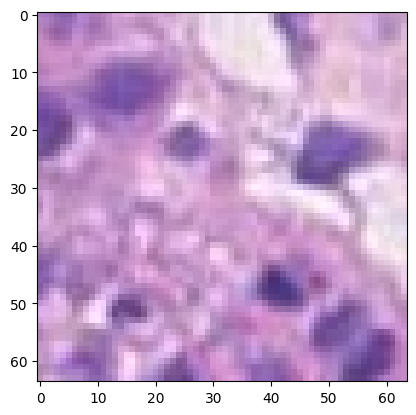

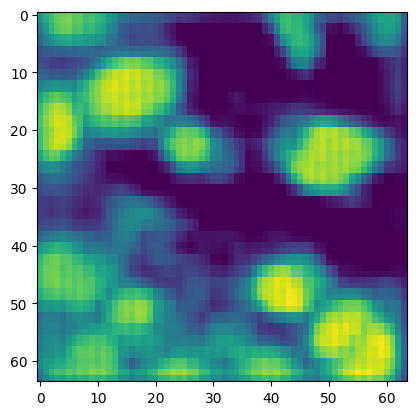

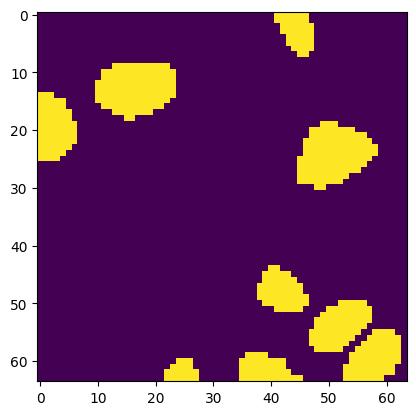

epoch 1/2, step 1100/25000, loss 336.66680879592894, acc 0.2490086704492569, time 0:05:44.697314
epoch 1/2, step 1200/25000, loss 357.31448163986204, acc 0.28211963176727295, time 0:06:11.186937
epoch 1/2, step 1300/25000, loss 363.9624500274658, acc 0.24880649149417877, time 0:06:37.814302
epoch 1/2, step 1400/25000, loss 360.9564672470093, acc 0.352483332157135, time 0:07:06.551969
epoch 1/2, step 1500/25000, loss 361.00677700042723, acc 0.44925105571746826, time 0:07:35.283465
epoch 1/2, step 1600/25000, loss 352.3056523323059, acc 0.3524455726146698, time 0:08:04.491371
epoch 1/2, step 1700/25000, loss 352.128955745697, acc 0.39499443769454956, time 0:08:33.757356
epoch 1/2, step 1800/25000, loss 362.8308921813965, acc 0.32647523283958435, time 0:09:08.327005
epoch 1/2, step 1900/25000, loss 336.2224363327026, acc 0.24124033749103546, time 0:10:10.811658
epoch 1/2, step 2000/25000, loss 352.5026057243347, acc 0.2516428232192993, time 0:11:00.600332


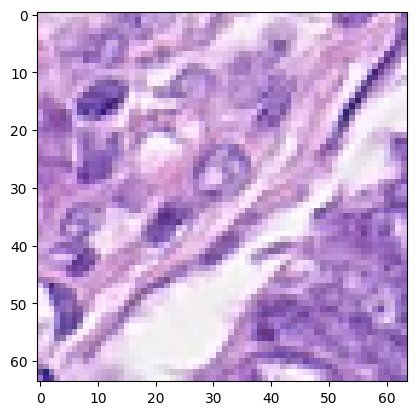

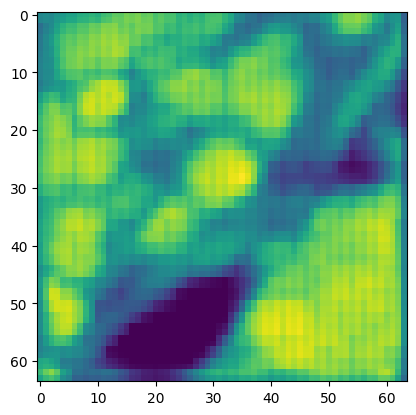

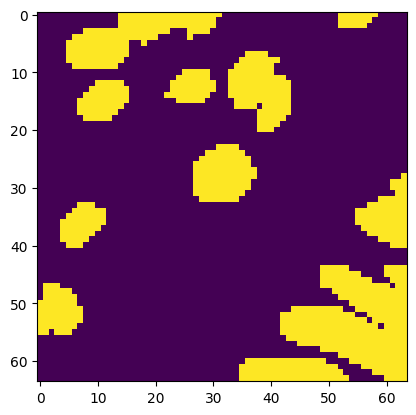

epoch 1/2, step 2100/25000, loss 359.31658401489256, acc 0.34645211696624756, time 0:11:49.689292
epoch 1/2, step 2200/25000, loss 349.1818719863892, acc 0.2668093740940094, time 0:12:33.505933
epoch 1/2, step 2300/25000, loss 358.82027559280397, acc 0.29945310950279236, time 0:13:07.432837
epoch 1/2, step 2400/25000, loss 339.2036810874939, acc 0.3098917305469513, time 0:13:41.125744
epoch 1/2, step 2500/25000, loss 342.02042112350466, acc 0.4227413237094879, time 0:14:11.519839
epoch 1/2, step 2600/25000, loss 367.87004680633544, acc 0.3555159568786621, time 0:14:49.819257
epoch 1/2, step 2700/25000, loss 342.1972484588623, acc 0.4522019922733307, time 0:15:25.914765
epoch 1/2, step 2800/25000, loss 358.61317291259763, acc 0.34919166564941406, time 0:16:00.078830
epoch 1/2, step 2900/25000, loss 342.1273220062256, acc 0.37072649598121643, time 0:16:35.870215
epoch 1/2, step 3000/25000, loss 345.91264753341676, acc 0.3496606647968292, time 0:17:07.745302


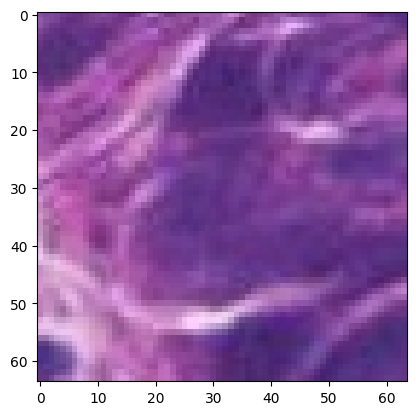

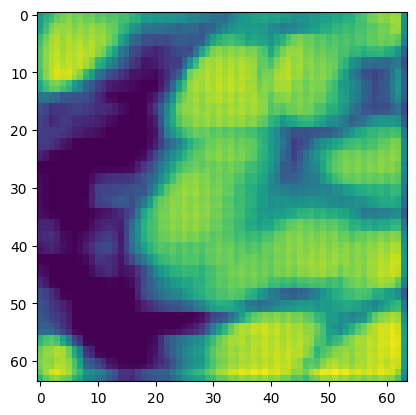

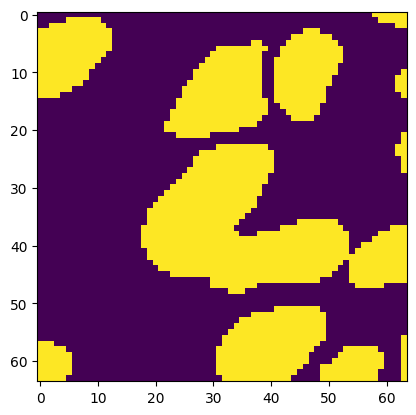

epoch 1/2, step 3100/25000, loss 345.65982456207274, acc 0.35099151730537415, time 0:17:42.193684
epoch 1/2, step 3200/25000, loss 345.5820739746094, acc 0.32530200481414795, time 0:18:23.140361
epoch 1/2, step 3300/25000, loss 352.3758551597595, acc 0.3825715482234955, time 0:19:04.270727
epoch 1/2, step 3400/25000, loss 347.7738510131836, acc 0.31009939312934875, time 0:19:46.250871
epoch 1/2, step 3500/25000, loss 339.64962682724, acc 0.3243089020252228, time 0:20:27.552124
epoch 1/2, step 3600/25000, loss 340.8116590499878, acc 0.3422354757785797, time 0:21:03.953916
epoch 1/2, step 3700/25000, loss 347.44328413009646, acc 0.4314332604408264, time 0:21:39.714005
epoch 1/2, step 3800/25000, loss 353.2124660015106, acc 0.3318421244621277, time 0:22:15.510198
epoch 1/2, step 3900/25000, loss 350.55584926605223, acc 0.4111277759075165, time 0:22:50.819988
epoch 1/2, step 4000/25000, loss 349.80477504730226, acc 0.38563352823257446, time 0:23:24.250135


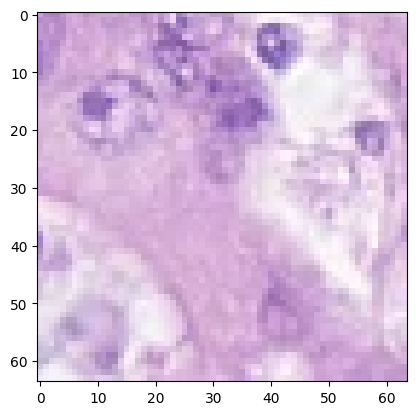

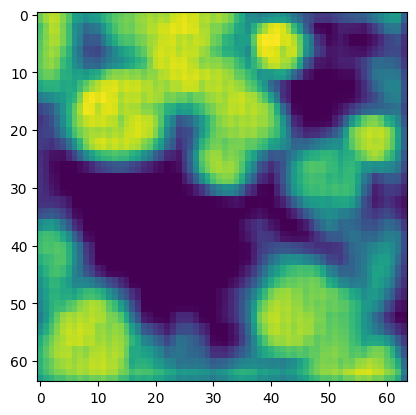

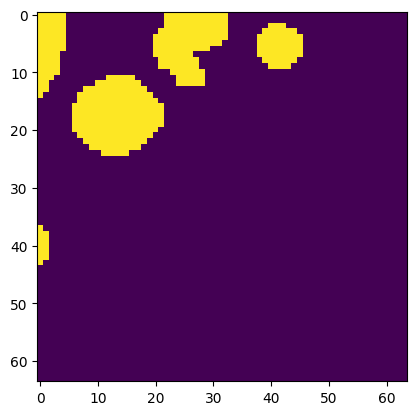

epoch 1/2, step 4100/25000, loss 342.0810180664063, acc 0.2939710021018982, time 0:24:00.607580
epoch 1/2, step 4200/25000, loss 344.4147235870361, acc 0.38069722056388855, time 0:24:31.146280
epoch 1/2, step 4300/25000, loss 356.45974826812744, acc 0.2623825967311859, time 0:25:07.237216
epoch 1/2, step 4400/25000, loss 360.097448348999, acc 0.2285851091146469, time 0:25:43.449654
epoch 1/2, step 4500/25000, loss 362.2053376197815, acc 0.25230973958969116, time 0:26:21.164297
epoch 1/2, step 4600/25000, loss 338.83856973648074, acc 0.32185423374176025, time 0:27:00.257198
epoch 1/2, step 4700/25000, loss 333.4893089294434, acc 0.3460249602794647, time 0:27:39.727115
epoch 1/2, step 4800/25000, loss 334.1512733459473, acc 0.31035926938056946, time 0:28:18.868239
epoch 1/2, step 4900/25000, loss 357.2895077705383, acc 0.3397809863090515, time 0:28:57.224872
epoch 1/2, step 5000/25000, loss 347.65475845336914, acc 0.3062750995159149, time 0:29:36.479492


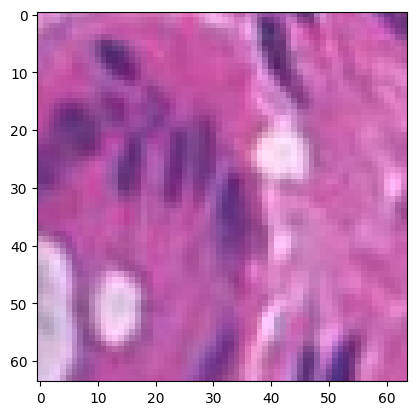

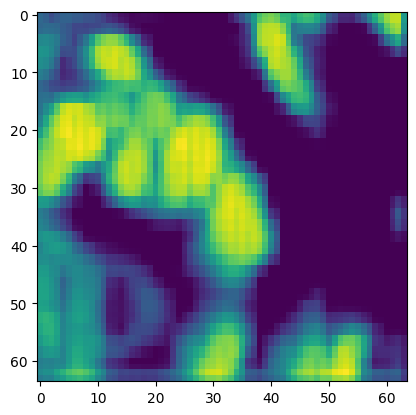

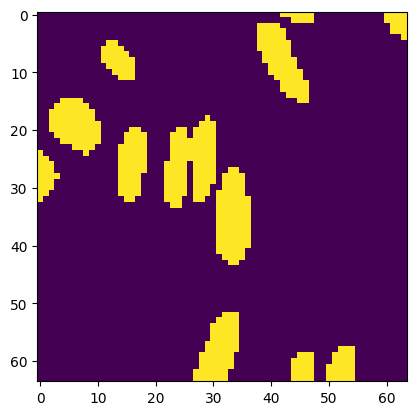

epoch 1/2, step 5100/25000, loss 350.44109802246095, acc 0.24228136241436005, time 0:30:11.169467
epoch 1/2, step 5200/25000, loss 352.8274471282959, acc 0.36927318572998047, time 0:30:50.545985
epoch 1/2, step 5300/25000, loss 358.190919303894, acc 0.3810936212539673, time 0:31:28.980303
epoch 1/2, step 5400/25000, loss 355.40260429382323, acc 0.23097485303878784, time 0:32:06.707943
epoch 1/2, step 5500/25000, loss 341.76712198257445, acc 0.4475729167461395, time 0:32:45.204209
epoch 1/2, step 5600/25000, loss 328.0475465774536, acc 0.37486594915390015, time 0:33:20.225229
epoch 1/2, step 5700/25000, loss 340.7147641181946, acc 0.23620767891407013, time 0:33:51.343605
epoch 1/2, step 5800/25000, loss 352.683424949646, acc 0.2203989177942276, time 0:34:22.826565
epoch 1/2, step 5900/25000, loss 355.6654525756836, acc 0.39337703585624695, time 0:34:52.848712
epoch 1/2, step 6000/25000, loss 347.26353998184203, acc 0.3498922884464264, time 0:35:21.782310


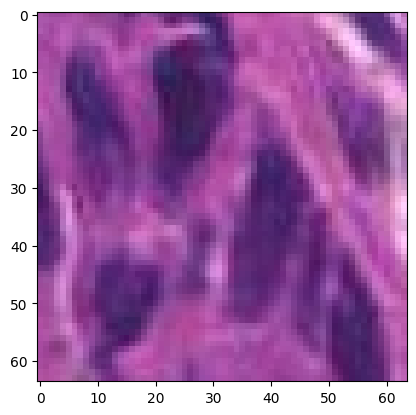

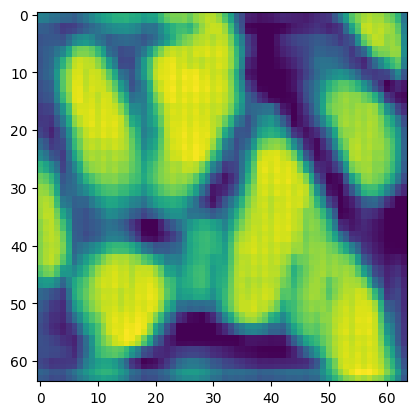

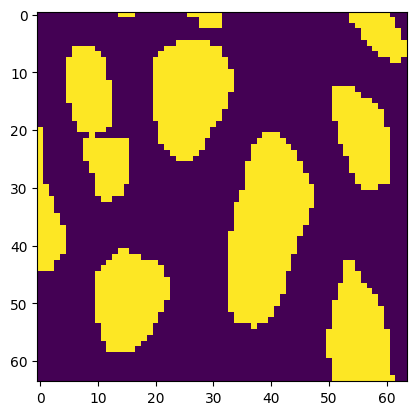

epoch 1/2, step 6100/25000, loss 357.2272925376892, acc 0.3903869688510895, time 0:35:55.641436
epoch 1/2, step 6200/25000, loss 339.8733438491821, acc 0.4122146964073181, time 0:36:33.446912
epoch 1/2, step 6300/25000, loss 341.09928288459776, acc 0.3378770351409912, time 0:37:11.811045
epoch 1/2, step 6400/25000, loss 353.09190940856934, acc 0.20410309731960297, time 0:38:04.006307
epoch 1/2, step 6500/25000, loss 338.5147204875946, acc 0.3036215603351593, time 0:38:48.842819
epoch 1/2, step 6600/25000, loss 342.5231707572937, acc 0.3310193419456482, time 0:39:25.576791
epoch 1/2, step 6700/25000, loss 340.3317063331604, acc 0.34744855761528015, time 0:40:03.223985
epoch 1/2, step 6800/25000, loss 347.6274921417236, acc 0.2242736965417862, time 0:40:42.659082
epoch 1/2, step 6900/25000, loss 342.48248863220215, acc 0.27856025099754333, time 0:41:20.001513
epoch 1/2, step 7000/25000, loss 353.44081535339353, acc 0.1576726734638214, time 0:41:55.860024


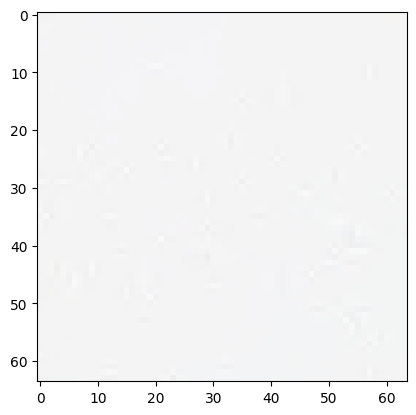

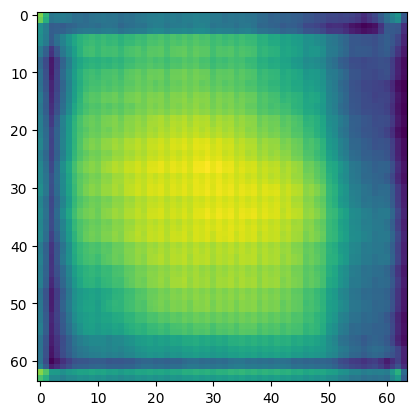

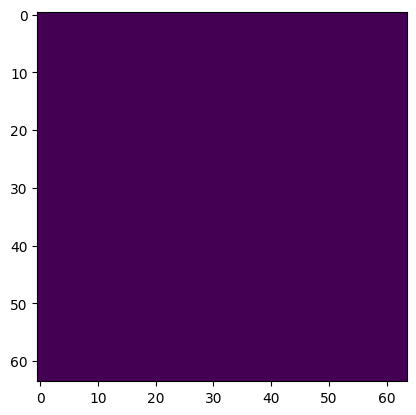

epoch 1/2, step 7100/25000, loss 333.50402841567995, acc 0.3987167477607727, time 0:42:33.079198
epoch 1/2, step 7200/25000, loss 355.4689230918884, acc 0.4039818346500397, time 0:43:25.324015
epoch 1/2, step 7300/25000, loss 358.5748643875122, acc 0.22569125890731812, time 0:44:13.485565
epoch 1/2, step 7400/25000, loss 362.1795513153076, acc 0.41642433404922485, time 0:44:59.311595
epoch 1/2, step 7500/25000, loss 357.69313926696776, acc 0.2121325433254242, time 0:45:40.612304
epoch 1/2, step 7600/25000, loss 332.71523122787477, acc 0.3238779902458191, time 0:46:26.539286
epoch 1/2, step 7700/25000, loss 365.2129084587097, acc 0.4039975106716156, time 0:47:21.384441
epoch 1/2, step 7800/25000, loss 342.5088782310486, acc 0.5410338044166565, time 0:48:05.831565
epoch 1/2, step 7900/25000, loss 352.7299505233765, acc 0.326240211725235, time 0:49:05.154332
epoch 1/2, step 8000/25000, loss 335.97172927856445, acc 0.3562339246273041, time 0:49:48.515218


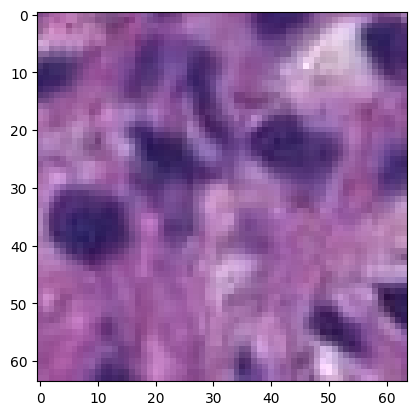

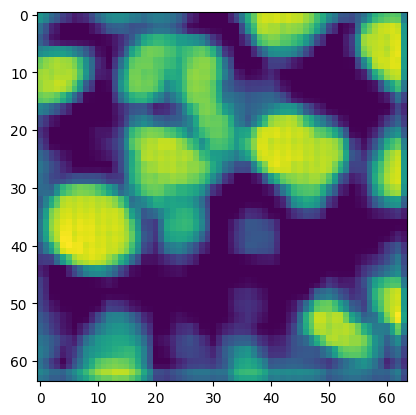

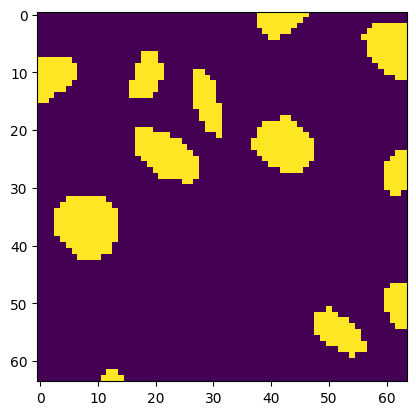

epoch 1/2, step 8100/25000, loss 359.21483888626096, acc 0.3857942819595337, time 0:50:22.823980
epoch 1/2, step 8200/25000, loss 338.6654040336609, acc 0.22701197862625122, time 0:50:59.953350
epoch 1/2, step 8300/25000, loss 340.1991216659546, acc 0.34487488865852356, time 0:51:40.175847
epoch 1/2, step 8400/25000, loss 357.3671413421631, acc 0.510880172252655, time 0:52:17.600668
epoch 1/2, step 8500/25000, loss 391.2466032028198, acc 0.30707311630249023, time 0:52:55.091969
epoch 1/2, step 8600/25000, loss 349.3969870567322, acc 0.3950020670890808, time 0:53:32.682560
epoch 1/2, step 8700/25000, loss 350.5970061302185, acc 0.2684205174446106, time 0:54:15.149169
epoch 1/2, step 8800/25000, loss 342.9245212554932, acc 0.2524101734161377, time 0:54:52.313406
epoch 1/2, step 8900/25000, loss 337.8277114868164, acc 0.22221459448337555, time 0:55:32.884432
epoch 1/2, step 9000/25000, loss 343.1579254150391, acc 0.3452405631542206, time 0:56:11.647506


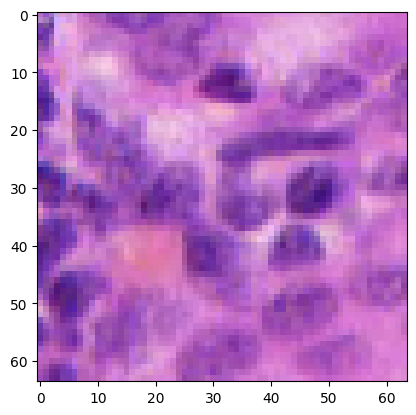

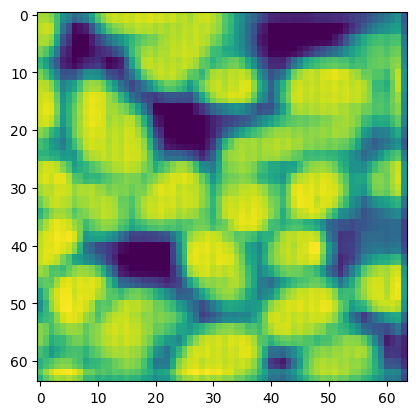

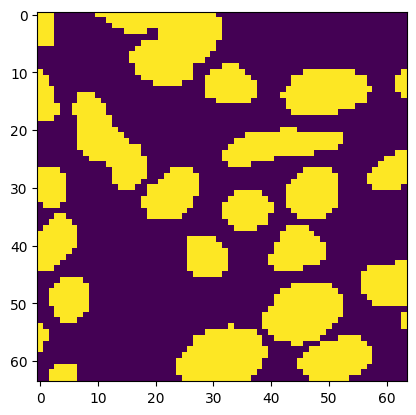

epoch 1/2, step 9100/25000, loss 342.6490407943726, acc 0.3878725469112396, time 0:56:49.143075
epoch 1/2, step 9200/25000, loss 360.95398197174075, acc 0.3025171458721161, time 0:57:23.554290
epoch 1/2, step 9300/25000, loss 370.3431562423706, acc 0.2733372747898102, time 0:57:58.761439
epoch 1/2, step 9400/25000, loss 360.3935966014862, acc 0.41510406136512756, time 0:58:35.777290
epoch 1/2, step 9500/25000, loss 364.4972785949707, acc 0.35972583293914795, time 0:59:13.571409
epoch 1/2, step 9600/25000, loss 341.2453279495239, acc 0.4319496154785156, time 0:59:46.953332
epoch 1/2, step 9700/25000, loss 341.1942861557007, acc 0.3897051513195038, time 1:00:22.162380
epoch 1/2, step 9800/25000, loss 349.1646879196167, acc 0.38255786895751953, time 1:00:56.758328
epoch 1/2, step 9900/25000, loss 342.0429539680481, acc 0.3309873342514038, time 1:01:30.960292
epoch 1/2, step 10000/25000, loss 356.50924644470217, acc 0.33836284279823303, time 1:02:05.815605


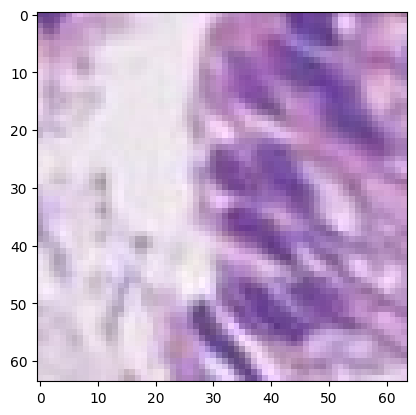

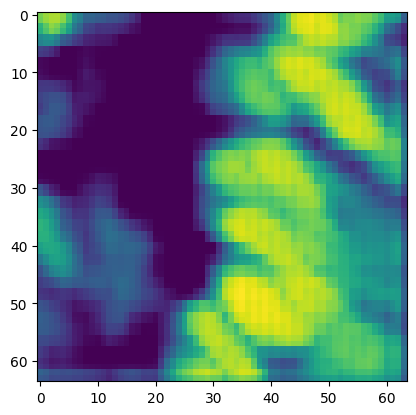

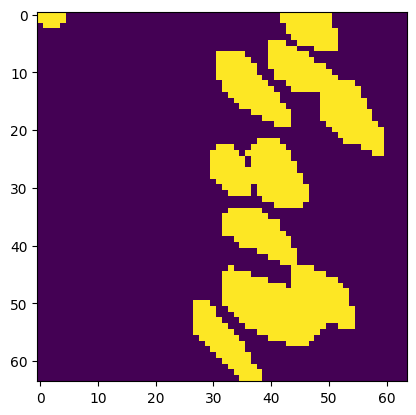

epoch 1/2, step 10100/25000, loss 352.0292736053467, acc 0.49722832441329956, time 1:02:39.420040
epoch 1/2, step 10200/25000, loss 336.4753151893616, acc 0.3446982204914093, time 1:03:12.590320
epoch 1/2, step 10300/25000, loss 359.09299182891846, acc 0.1630488932132721, time 1:03:46.444877
epoch 1/2, step 10400/25000, loss 359.0691743850708, acc 0.36658748984336853, time 1:04:20.065649
epoch 1/2, step 10500/25000, loss 364.4828296661377, acc 0.3873281180858612, time 1:04:51.814357
epoch 1/2, step 10600/25000, loss 351.6998559474945, acc 0.1939675211906433, time 1:05:23.811857
epoch 1/2, step 10700/25000, loss 352.07666473388673, acc 0.42095914483070374, time 1:05:55.574398
epoch 1/2, step 10800/25000, loss 351.23159675598146, acc 0.4506419897079468, time 1:06:24.185942
epoch 1/2, step 10900/25000, loss 343.9010175704956, acc 0.25659847259521484, time 1:06:51.870745
epoch 1/2, step 11000/25000, loss 354.3115697860718, acc 0.3765925467014313, time 1:07:19.467304


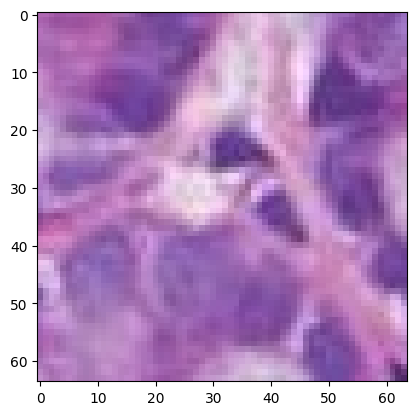

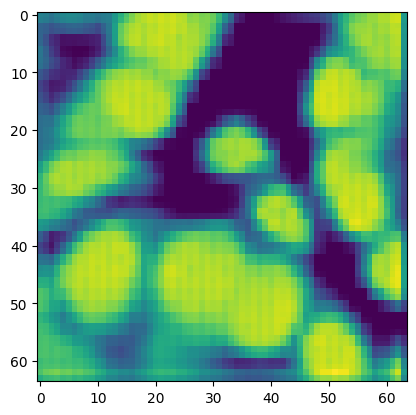

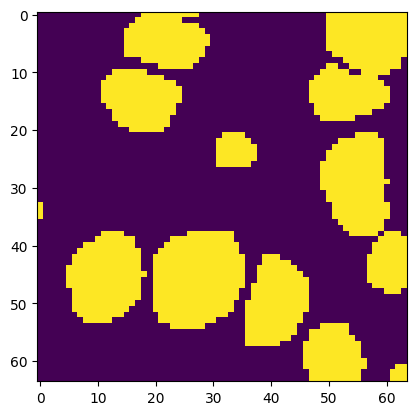

epoch 1/2, step 11100/25000, loss 346.40484523773193, acc 0.28890934586524963, time 1:07:47.085937
epoch 1/2, step 11200/25000, loss 346.0257689476013, acc 0.43621528148651123, time 1:08:17.414138
epoch 1/2, step 11300/25000, loss 335.5813060760498, acc 0.2272922694683075, time 1:08:47.403382
epoch 1/2, step 11400/25000, loss 338.9579557418823, acc 0.20395545661449432, time 1:09:14.608116
epoch 1/2, step 11500/25000, loss 343.96766505241396, acc 0.42941194772720337, time 1:09:40.707141
epoch 1/2, step 11600/25000, loss 324.55782289505004, acc 0.37263453006744385, time 1:10:06.372459
epoch 1/2, step 11700/25000, loss 331.72783756256104, acc 0.2913501262664795, time 1:10:34.571891
epoch 1/2, step 11800/25000, loss 328.69427309036257, acc 0.34868741035461426, time 1:11:00.994126
epoch 1/2, step 11900/25000, loss 344.831466293335, acc 0.24027812480926514, time 1:11:26.891268
epoch 1/2, step 12000/25000, loss 357.89835743904115, acc 0.47683751583099365, time 1:11:52.703691


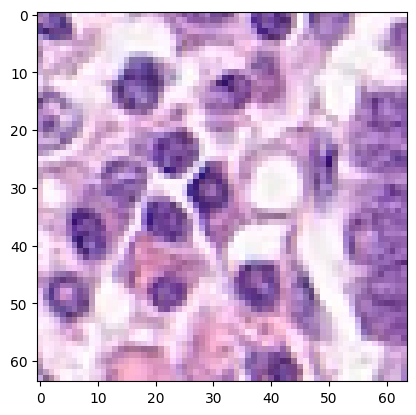

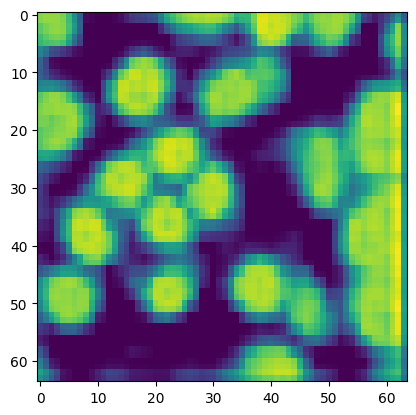

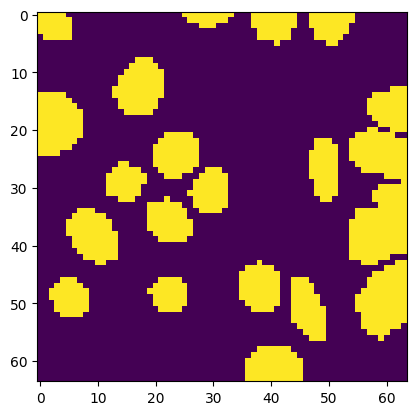

epoch 1/2, step 12100/25000, loss 345.4736482620239, acc 0.15049432218074799, time 1:12:18.912644
epoch 1/2, step 12200/25000, loss 341.2099088668823, acc 0.38509318232536316, time 1:12:44.567414
epoch 1/2, step 12300/25000, loss 376.2295029640198, acc 0.23719732463359833, time 1:13:10.859819
epoch 1/2, step 12400/25000, loss 358.56455726623534, acc 0.25824177265167236, time 1:13:46.235090
epoch 1/2, step 12500/25000, loss 352.56257915496826, acc 0.5110398530960083, time 1:14:18.636462
epoch 1/2, step 12600/25000, loss 361.9947127342224, acc 0.3443954885005951, time 1:14:49.929893
epoch 1/2, step 12700/25000, loss 352.3399028778076, acc 0.34803760051727295, time 1:15:20.914328
epoch 1/2, step 12800/25000, loss 350.20771555900575, acc 0.4302011728286743, time 1:15:51.491797
epoch 1/2, step 12900/25000, loss 339.5172330856323, acc 0.34869077801704407, time 1:16:35.348390
epoch 1/2, step 13000/25000, loss 346.1804595947266, acc 0.23174458742141724, time 1:17:07.286615


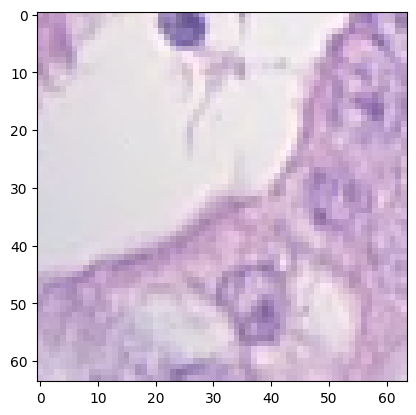

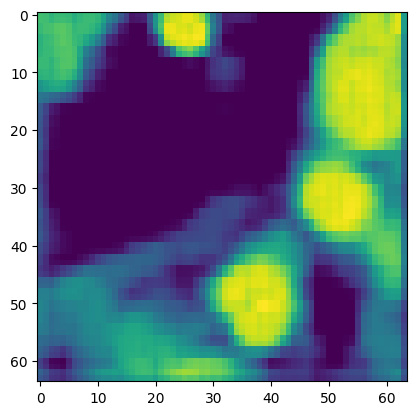

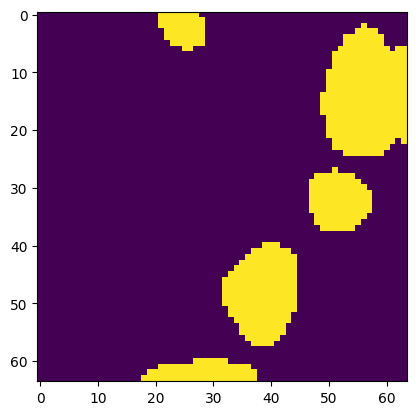

epoch 1/2, step 13100/25000, loss 344.595161151886, acc 0.24343930184841156, time 1:17:45.603207
epoch 1/2, step 13200/25000, loss 342.293185710907, acc 0.18768411874771118, time 1:18:24.130150
epoch 1/2, step 13300/25000, loss 334.64578704833986, acc 0.3081218898296356, time 1:18:58.280698
epoch 1/2, step 13400/25000, loss 356.27106351852416, acc 0.23293961584568024, time 1:19:49.515763
epoch 1/2, step 13500/25000, loss 335.77441625595094, acc 0.29256659746170044, time 1:20:43.071877
epoch 1/2, step 13600/25000, loss 353.04790964126585, acc 0.33480387926101685, time 1:21:24.012795
epoch 1/2, step 13700/25000, loss 339.13363256454465, acc 0.29376906156539917, time 1:22:04.151344
epoch 1/2, step 13800/25000, loss 349.3500030517578, acc 0.40549781918525696, time 1:22:48.340884
epoch 1/2, step 13900/25000, loss 338.47729482650755, acc 0.49251052737236023, time 1:23:26.312078
epoch 1/2, step 14000/25000, loss 339.410223197937, acc 0.26443609595298767, time 1:24:03.214782


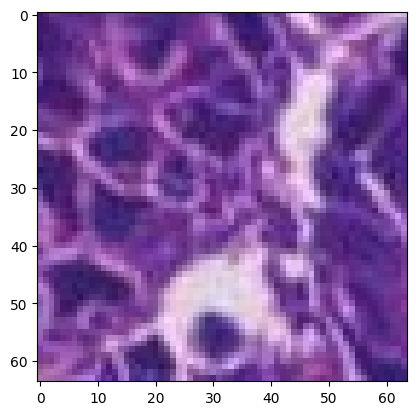

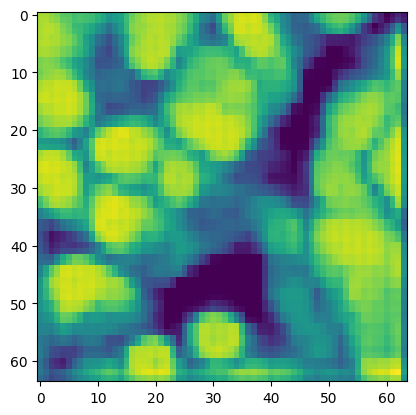

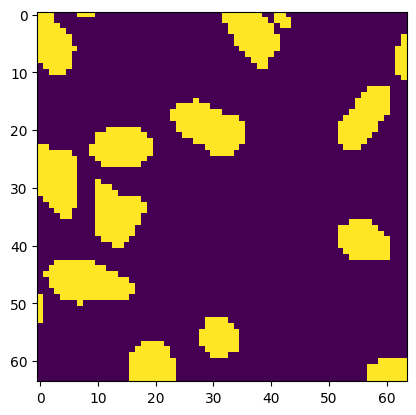

epoch 1/2, step 14100/25000, loss 351.85939874649046, acc 0.3090251088142395, time 1:24:45.369965
epoch 1/2, step 14200/25000, loss 331.9251566886902, acc 0.3164280951023102, time 1:25:19.271094
epoch 1/2, step 14300/25000, loss 351.0746645927429, acc 0.32981088757514954, time 1:25:52.095740
epoch 1/2, step 14400/25000, loss 340.55450963974, acc 0.5267958045005798, time 1:26:31.542504
epoch 1/2, step 14500/25000, loss 336.92312688827514, acc 0.2795775532722473, time 1:27:08.344677
epoch 1/2, step 14600/25000, loss 345.8877552986145, acc 0.4321977198123932, time 1:27:44.638494
epoch 1/2, step 14700/25000, loss 316.332400226593, acc 0.23628541827201843, time 1:28:19.041693
epoch 1/2, step 14800/25000, loss 350.8617992401123, acc 0.37312227487564087, time 1:28:55.503915
epoch 1/2, step 14900/25000, loss 347.7156530380249, acc 0.45759105682373047, time 1:29:32.073764
epoch 1/2, step 15000/25000, loss 337.4357138633728, acc 0.19713623821735382, time 1:30:09.820583


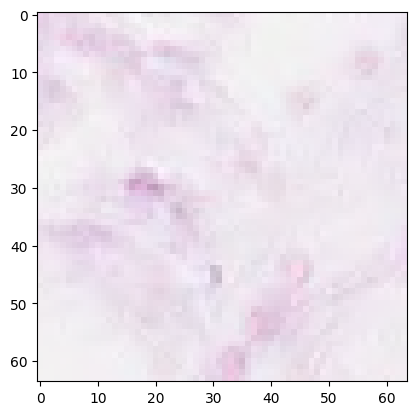

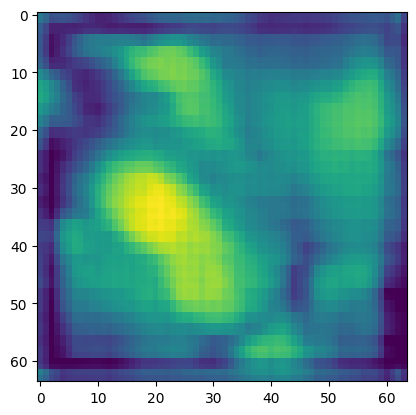

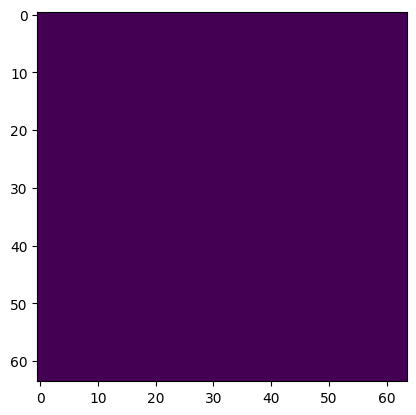

epoch 1/2, step 15100/25000, loss 350.798169708252, acc 0.30624231696128845, time 1:30:50.334533
epoch 1/2, step 15200/25000, loss 341.466263961792, acc 0.4262637794017792, time 1:31:26.472253
epoch 1/2, step 15300/25000, loss 352.00407009124757, acc 0.2789894640445709, time 1:32:03.304016
epoch 1/2, step 15400/25000, loss 350.4936611175537, acc 0.29551470279693604, time 1:32:40.246463
epoch 1/2, step 15500/25000, loss 352.7342148780823, acc 0.2827453017234802, time 1:33:18.580186
epoch 1/2, step 15600/25000, loss 339.02668619155884, acc 0.34507879614830017, time 1:34:02.086563
epoch 1/2, step 15700/25000, loss 338.2566650390625, acc 0.44861626625061035, time 1:34:42.867351
epoch 1/2, step 15800/25000, loss 342.4520980834961, acc 0.3805764317512512, time 1:35:36.545003
epoch 1/2, step 15900/25000, loss 350.1627707481384, acc 0.3418833613395691, time 1:36:46.361900
epoch 1/2, step 16000/25000, loss 334.50867319107056, acc 0.43616101145744324, time 1:38:04.022281


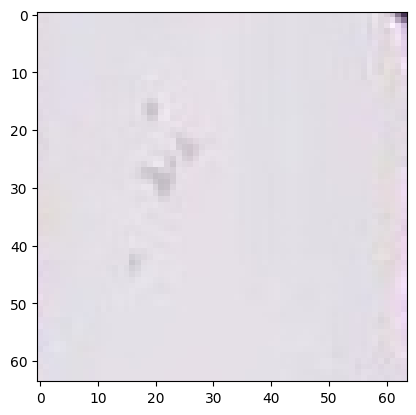

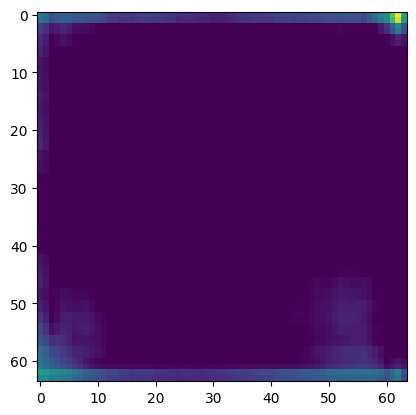

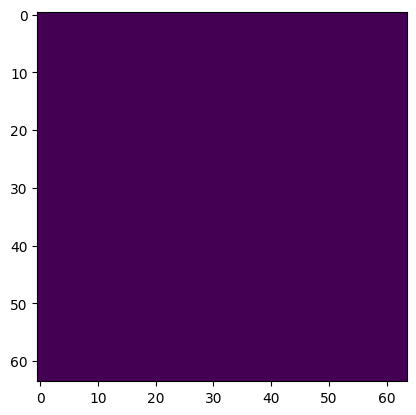

epoch 1/2, step 16100/25000, loss 346.9305486679077, acc 0.43748319149017334, time 1:38:49.047468
epoch 1/2, step 16200/25000, loss 362.53494596481323, acc 0.37219592928886414, time 1:39:32.954689
epoch 1/2, step 16300/25000, loss 344.7612711906433, acc 0.37699416279792786, time 1:40:18.376336
epoch 1/2, step 16400/25000, loss 343.66466627120974, acc 0.4013025760650635, time 1:41:00.361541
epoch 1/2, step 16500/25000, loss 346.5894624710083, acc 0.2031843364238739, time 1:41:47.564242
epoch 1/2, step 16600/25000, loss 333.6559705734253, acc 0.43077126145362854, time 1:42:29.821921
epoch 1/2, step 16700/25000, loss 339.1718952178955, acc 0.36351892352104187, time 1:43:11.233851
epoch 1/2, step 16800/25000, loss 337.1915844917297, acc 0.41621658205986023, time 1:43:55.782735
epoch 1/2, step 16900/25000, loss 354.4590208053589, acc 0.4220607578754425, time 1:44:39.839232
epoch 1/2, step 17000/25000, loss 361.3027271270752, acc 0.4186963737010956, time 1:45:23.944964


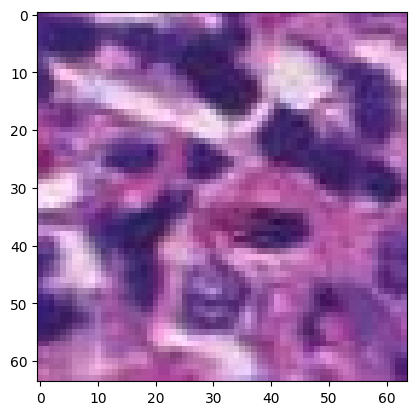

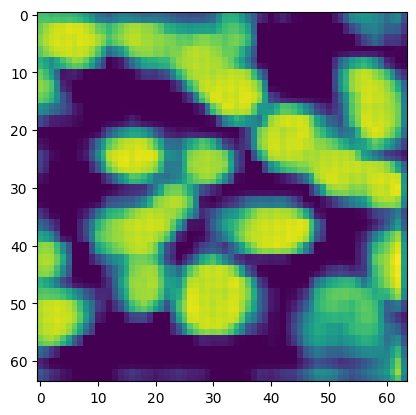

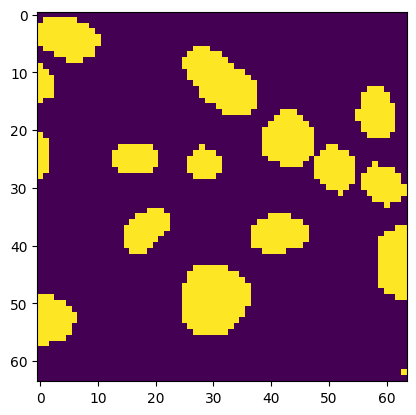

epoch 1/2, step 17100/25000, loss 326.42903594970704, acc 0.4478289783000946, time 1:46:12.773749
epoch 1/2, step 17200/25000, loss 326.2910267829895, acc 0.4112919569015503, time 1:46:53.098416
epoch 1/2, step 17300/25000, loss 334.63166999816895, acc 0.42242804169654846, time 1:47:35.173681
epoch 1/2, step 17400/25000, loss 345.9976531028748, acc 0.4551219344139099, time 1:48:15.917598
epoch 1/2, step 17500/25000, loss 343.3568508148193, acc 0.36504238843917847, time 1:48:54.256561
epoch 1/2, step 17600/25000, loss 341.24548053741455, acc 0.2930375337600708, time 1:49:40.348116
epoch 1/2, step 17700/25000, loss 342.7429088592529, acc 0.22724714875221252, time 1:50:19.348834
epoch 1/2, step 17800/25000, loss 324.41423749923706, acc 0.4306332767009735, time 1:50:58.179853
epoch 1/2, step 17900/25000, loss 323.9552547454834, acc 0.4037315547466278, time 1:51:36.423117
epoch 1/2, step 18000/25000, loss 347.9479177951813, acc 0.3961665630340576, time 1:52:22.584578


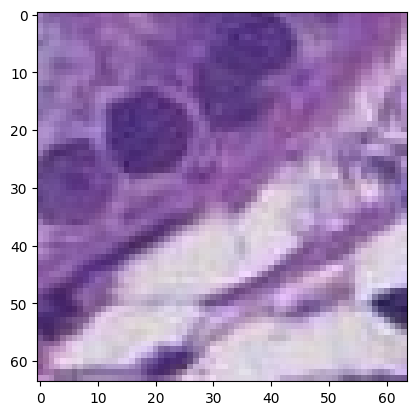

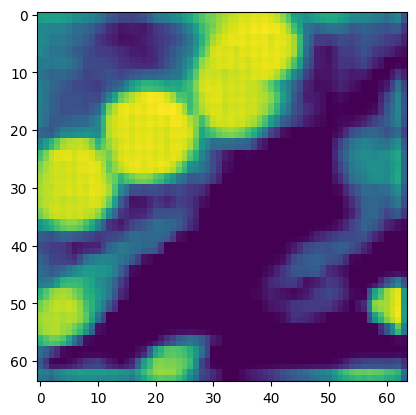

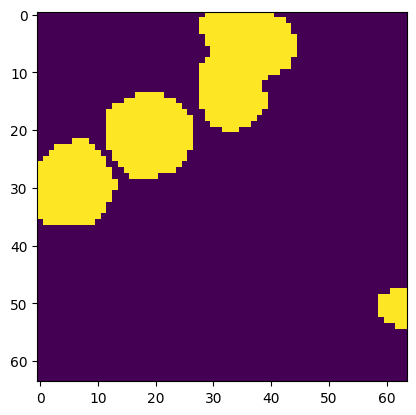

epoch 1/2, step 18100/25000, loss 338.67555084228513, acc 0.34008345007896423, time 1:53:05.450265
epoch 1/2, step 18200/25000, loss 351.8417211532593, acc 0.4113633334636688, time 1:53:43.992568
epoch 1/2, step 18300/25000, loss 359.00581855773925, acc 0.2841093838214874, time 1:54:21.441139
epoch 1/2, step 18400/25000, loss 338.9822240829468, acc 0.5195242762565613, time 1:55:00.854550
epoch 1/2, step 18500/25000, loss 344.06683387756345, acc 0.49294328689575195, time 1:55:37.285239
epoch 1/2, step 18600/25000, loss 344.4557372093201, acc 0.3318230211734772, time 1:56:21.561125
epoch 1/2, step 18700/25000, loss 336.2326735496521, acc 0.22399422526359558, time 1:57:05.627016
epoch 1/2, step 18800/25000, loss 330.10438137054444, acc 0.3527918756008148, time 1:57:50.592009
epoch 1/2, step 18900/25000, loss 369.12407569885255, acc 0.4115988314151764, time 1:58:34.733967
epoch 1/2, step 19000/25000, loss 345.6635762214661, acc 0.23868609964847565, time 1:59:18.536459


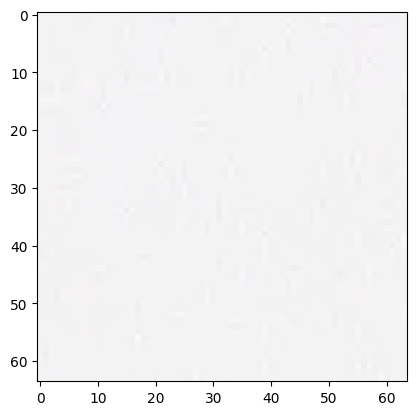

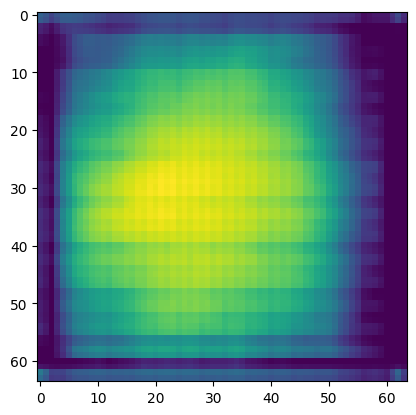

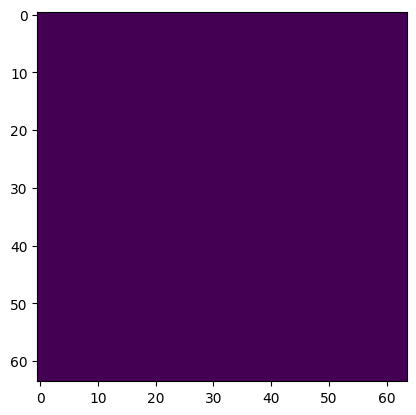

epoch 1/2, step 19100/25000, loss 337.3988513946533, acc 0.2871894836425781, time 2:00:03.114141
epoch 1/2, step 19200/25000, loss 329.03759346008303, acc 0.38246211409568787, time 2:00:50.215748
epoch 1/2, step 19300/25000, loss 362.9721360206604, acc 0.40963131189346313, time 2:01:30.917591
epoch 1/2, step 19400/25000, loss 342.2193095207214, acc 0.3475985527038574, time 2:02:11.346897
epoch 1/2, step 19500/25000, loss 342.8994285583496, acc 0.30164194107055664, time 2:02:50.009155
epoch 1/2, step 19600/25000, loss 330.51881046295165, acc 0.35792312026023865, time 2:03:27.724447
epoch 1/2, step 19700/25000, loss 346.6026435852051, acc 0.5169530510902405, time 2:04:05.269267
epoch 1/2, step 19800/25000, loss 349.52089195251466, acc 0.2730129063129425, time 2:04:42.201747
epoch 1/2, step 19900/25000, loss 349.9025528907776, acc 0.434346467256546, time 2:05:19.029100
epoch 1/2, step 20000/25000, loss 349.6003785133362, acc 0.296016126871109, time 2:06:00.924843


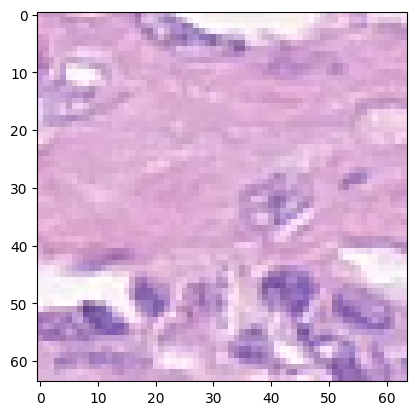

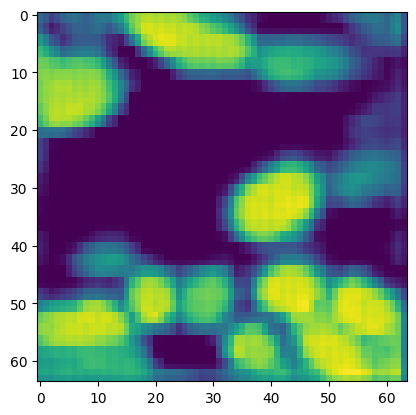

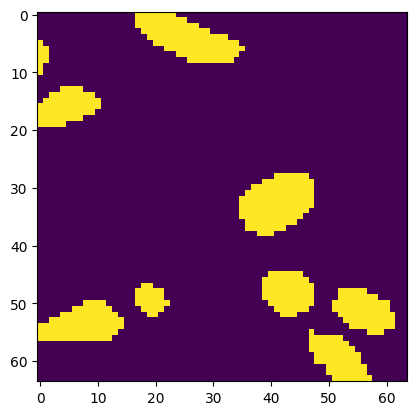

epoch 1/2, step 20100/25000, loss 341.56704845428465, acc 0.3422470986843109, time 2:06:44.106211
epoch 1/2, step 20200/25000, loss 340.07843389511106, acc 0.4071516692638397, time 2:07:20.148836
epoch 1/2, step 20300/25000, loss 349.30768995285035, acc 0.24824033677577972, time 2:07:57.650258
epoch 1/2, step 20400/25000, loss 334.77719192504884, acc 0.3208466172218323, time 2:08:46.924147
epoch 1/2, step 20500/25000, loss 335.90362920761106, acc 0.36674290895462036, time 2:09:35.937461
epoch 1/2, step 20600/25000, loss 345.55962285995486, acc 0.5011021494865417, time 2:10:19.776650
epoch 1/2, step 20700/25000, loss 362.4164339065552, acc 0.27603602409362793, time 2:11:09.368682
epoch 1/2, step 20800/25000, loss 340.402303314209, acc 0.37123996019363403, time 2:11:45.842009
epoch 1/2, step 20900/25000, loss 333.7551899433136, acc 0.26661068201065063, time 2:12:22.313940
epoch 1/2, step 21000/25000, loss 338.2445037841797, acc 0.3298392593860626, time 2:12:57.726411


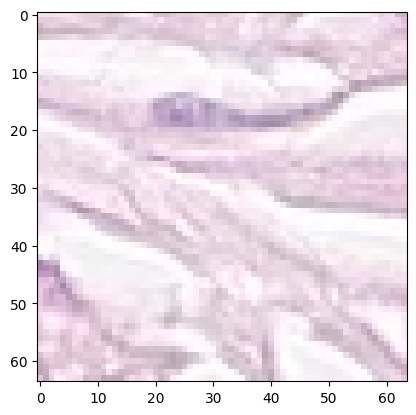

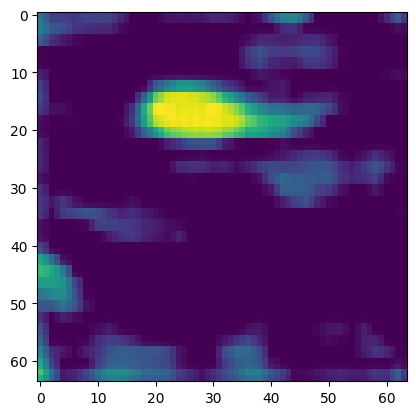

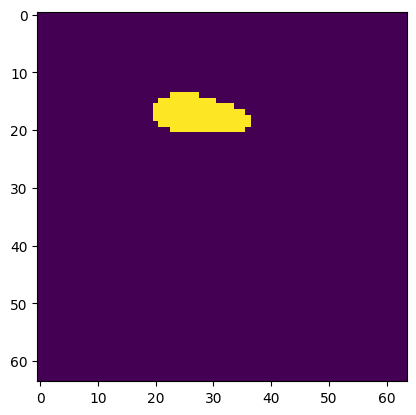

epoch 1/2, step 21100/25000, loss 342.2097124099731, acc 0.35996177792549133, time 2:13:35.718658
epoch 1/2, step 21200/25000, loss 335.57426595687866, acc 0.38815224170684814, time 2:14:20.034141
epoch 1/2, step 21300/25000, loss 335.03997898101807, acc 0.29146456718444824, time 2:14:56.384276
epoch 1/2, step 21400/25000, loss 350.6530311584473, acc 0.37038788199424744, time 2:15:32.808299
epoch 1/2, step 21500/25000, loss 327.0875566482544, acc 0.2454954981803894, time 2:16:23.980557
epoch 1/2, step 21600/25000, loss 343.4545639038086, acc 0.30490902066230774, time 2:17:08.352844
epoch 1/2, step 21700/25000, loss 357.69336929321287, acc 0.4843963384628296, time 2:17:49.639810
epoch 1/2, step 21800/25000, loss 351.7625954627991, acc 0.47306716442108154, time 2:18:30.394379
epoch 1/2, step 21900/25000, loss 333.5574080467224, acc 0.3355339765548706, time 2:19:09.722979
epoch 1/2, step 22000/25000, loss 356.2733624458313, acc 0.4145376980304718, time 2:19:46.289697


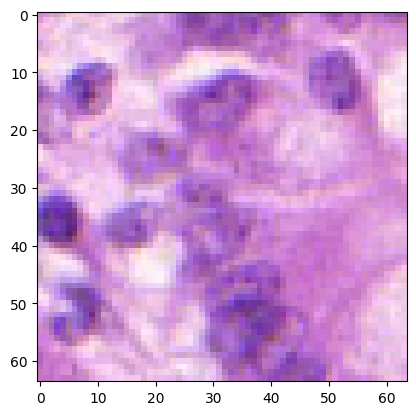

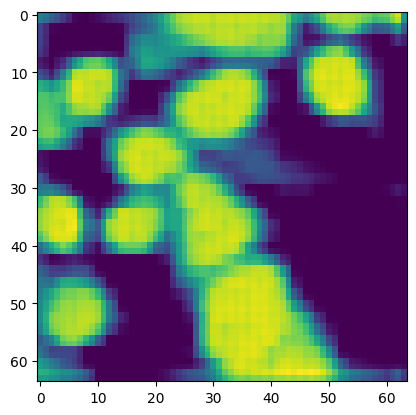

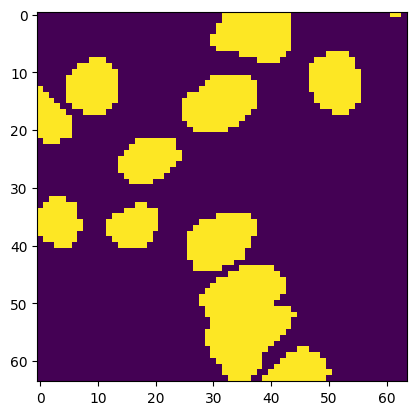

epoch 1/2, step 22100/25000, loss 360.5953150749207, acc 0.480010449886322, time 2:20:27.542784
epoch 1/2, step 22200/25000, loss 340.7750715255737, acc 0.257587194442749, time 2:21:03.154772
epoch 1/2, step 22300/25000, loss 351.44269104003905, acc 0.4313216209411621, time 2:21:38.057839
epoch 1/2, step 22400/25000, loss 340.4622003555298, acc 0.3024209439754486, time 2:22:17.480489
epoch 1/2, step 22500/25000, loss 354.9997887611389, acc 0.33178508281707764, time 2:22:54.829356
epoch 1/2, step 22600/25000, loss 353.7452739715576, acc 0.41426020860671997, time 2:23:29.771220
epoch 1/2, step 22700/25000, loss 343.88778390884397, acc 0.322732537984848, time 2:24:03.352687
epoch 1/2, step 22800/25000, loss 321.9089920043945, acc 0.3268308639526367, time 2:24:38.617845
epoch 1/2, step 22900/25000, loss 335.29712810516355, acc 0.35252103209495544, time 2:25:14.680469
epoch 1/2, step 23000/25000, loss 348.4862675666809, acc 0.4662153124809265, time 2:25:50.043974


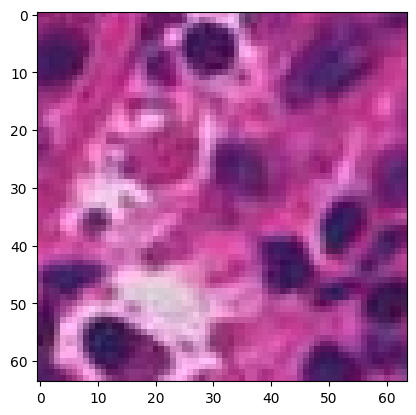

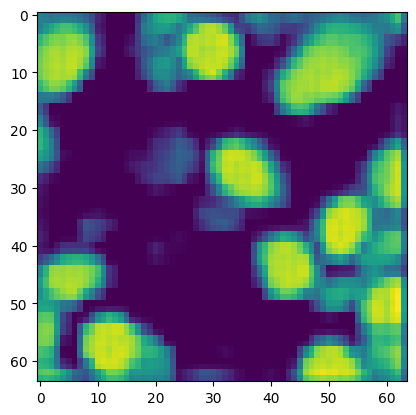

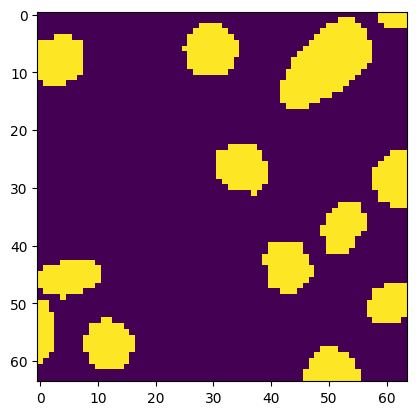

epoch 1/2, step 23100/25000, loss 342.6468179702759, acc 0.3036191463470459, time 2:26:30.735496
epoch 1/2, step 23200/25000, loss 339.15611934661865, acc 0.3777807056903839, time 2:27:09.540651
epoch 1/2, step 23300/25000, loss 347.60755729675293, acc 0.35565850138664246, time 2:27:45.312059
epoch 1/2, step 23400/25000, loss 350.86068243980407, acc 0.329512357711792, time 2:28:21.309373
epoch 1/2, step 23500/25000, loss 358.49882373809817, acc 0.41839125752449036, time 2:28:56.160049


KeyboardInterrupt: 

In [9]:
start_time = datetime.now()
for epoch in range(num_epochs):
    avg_loss = 0
    for i, (inputs, labels) in enumerate(dataloader):
        opt.zero_grad()
        outputs = net(inputs.float())
        loss = loss_fn(outputs.squeeze(1), labels.float())
        
        loss.backward()
        opt.step()
        acc = dice(outputs, labels)
        wandb.log({"loss_2": loss})
        wandb.log({"acc_2": acc})
        avg_loss += loss.item()
        if (i+1) % 100 == 0:
            print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_iterations}, loss {avg_loss/10}, acc {acc}, time {(datetime.now()-start_time)}')
            avg_loss = 0
        if (i+1) % 1000 == 0:
            plt.imshow(inputs[0].permute((1, 2, 0)).detach().numpy()/255)
            plt.show()
            plt.imshow(outputs[0][0].detach().numpy())
            plt.show()
            plt.imshow(labels[0].detach().numpy())
            plt.show()

In [14]:
torch.save(net, "unet_cross_adam_001_64_2")

In [7]:
net = UNET(3, 1)
net = torch.load("unet_cross_adam_001_64_1")
# net24 - CrossEntropy

tensor(0.4319)


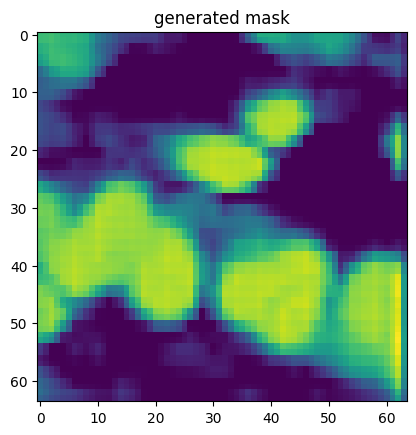

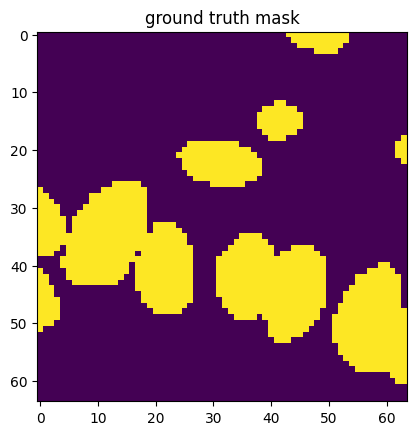

In [11]:
dataloader_test = DataLoader(dataset=test_data, batch_size=1, shuffle=True)
dataiter = iter(dataloader)
data = next(dataiter)
features, labels = data
with torch.no_grad():
    outputs = net(features.float())
    print(dice(outputs, labels))
    plt.imshow(outputs[0][0].detach().numpy())
    plt.title("generated mask")
    plt.show()
    plt.imshow(labels[0].detach().numpy())
    plt.title("ground truth mask")
    plt.show()

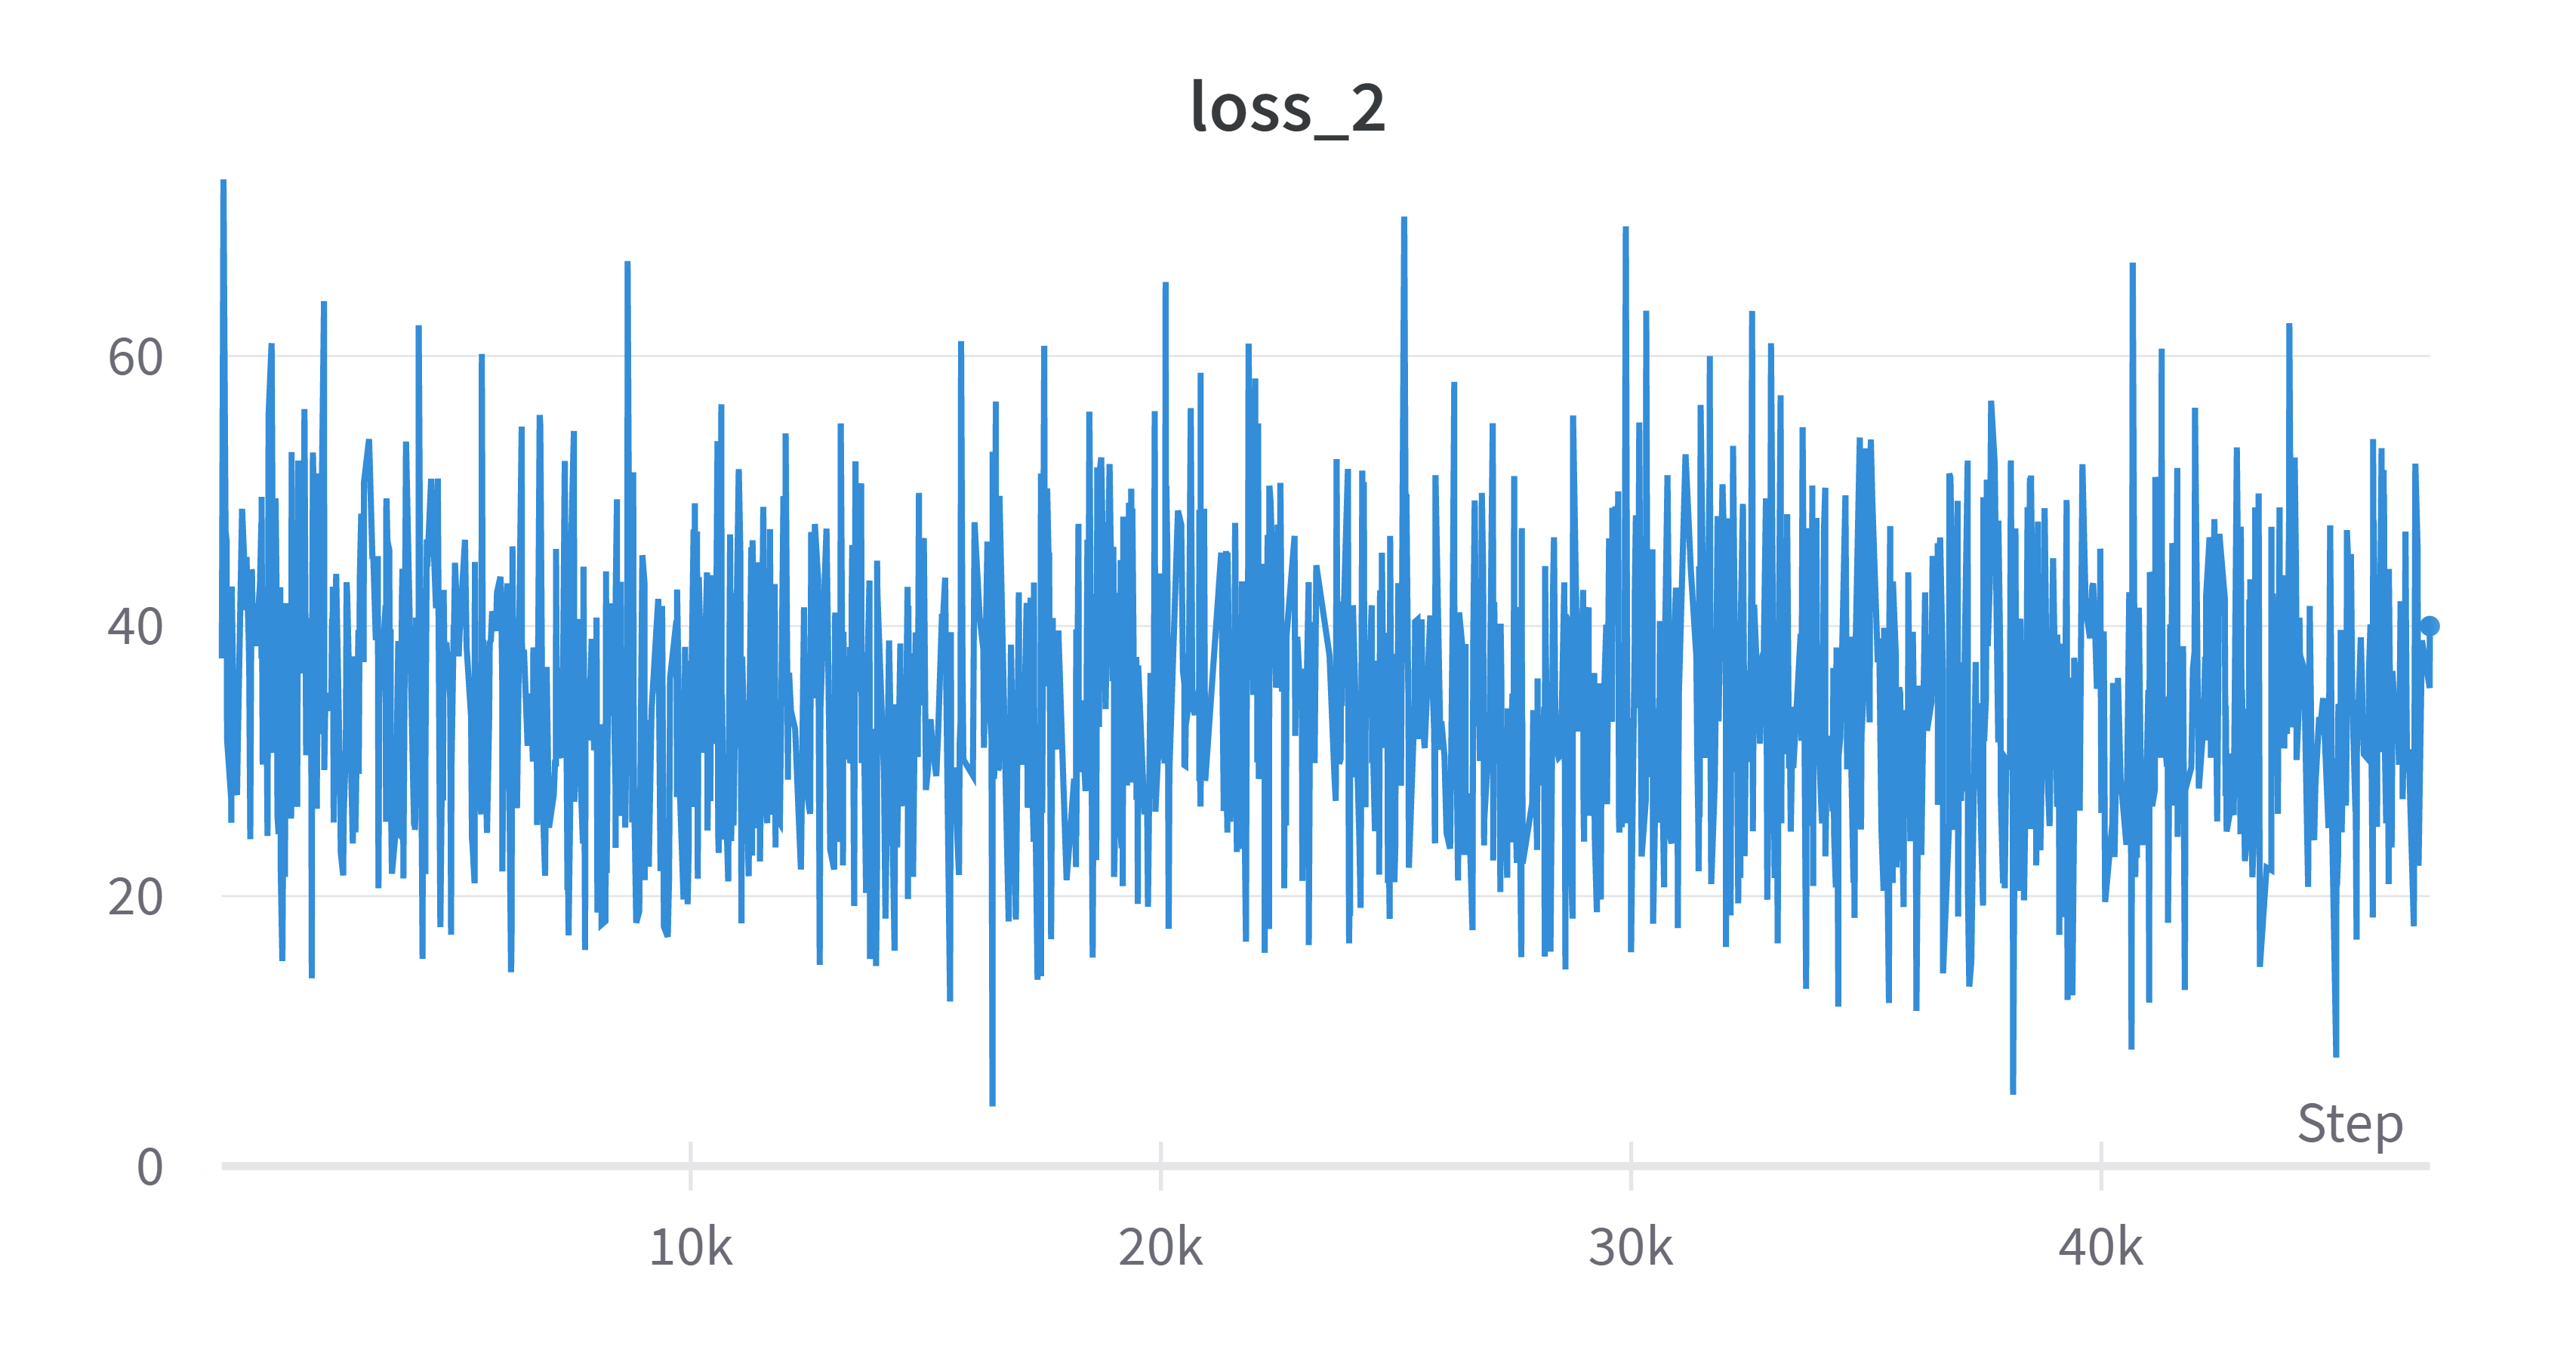

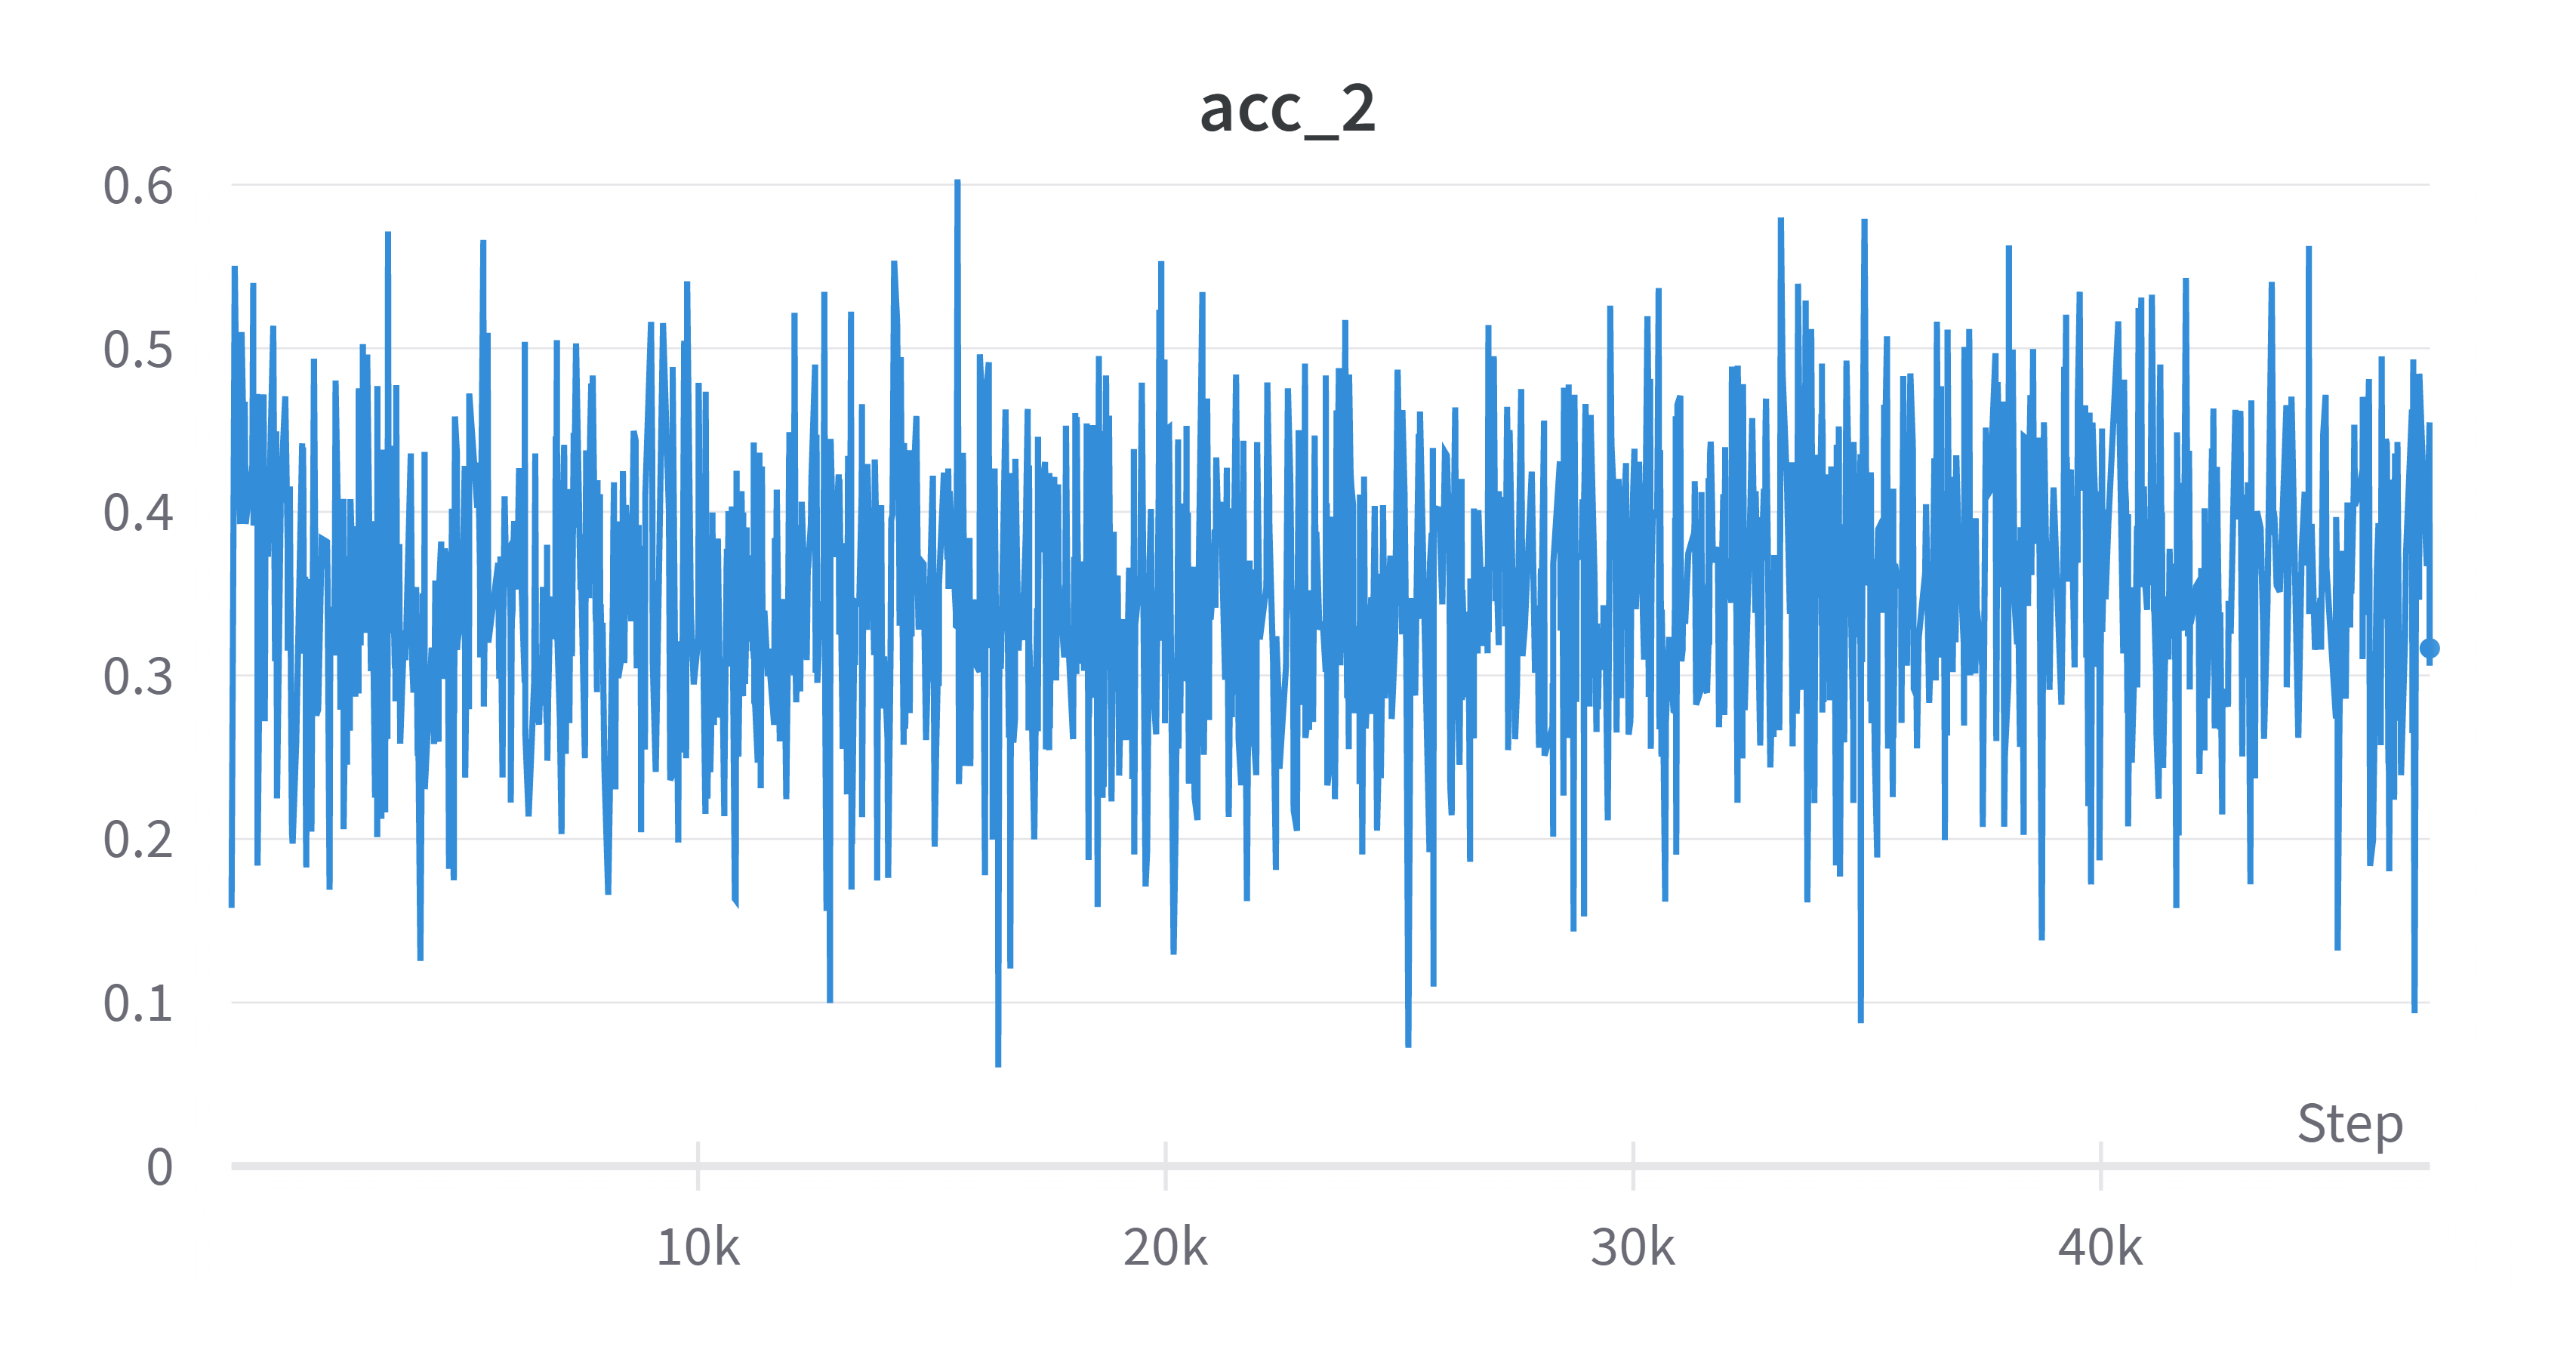

epoch 1/2, step 23500/25000, loss 358.49882373809817, acc 0.41839125752449036, time 2:28:56.160049

CrossEntropyLoss, SGD at 0.01, Dice score (acc)

batch 4